In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as colors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from collections import Counter

# custom libs
from Task_1 import custom_log_reg
from Prova_1 import LogisticRegression

import numpy as np
import warnings

# suppress warnings since we are using exp and large number for the first iterates! 
warnings.filterwarnings('ignore')

# Task 1: build a kernelized logistic regressor

To implement the kernel logistic regression I created a dedicate class which contained 3 modules:

- **fit:** the function first cast the input to a numpy.array (I added this part since it is easier to handle data in a pandas DF format) and then I saved the number of instances (m). Then I computed the kernel matrix with the function that was instantiated when initializing the function using the keywords "gaussian" or "linear" (notice that only a RBF and a Linear Kernel are implemented at the moment! The kernel matrix is then saved inside the class. To add more kernel it is necessary to update the __init__ module of the class and to create the appropriate kernel function. I did not add them since only the RBF kernel was requested, but I implemented a scalable function, like requested in the assignment). Then I initialize a vector of zeros for the alpha weights with the same dimension as the numebr of instances. Subsequently I implemented the vanilla GD (executed for max_iter iterations) computing the gradient of the logistic regression cost function (see the code for the math). Finally I saved the logistic regression cost at the current iteration in a list and I returned it. The tuned weights are saved inside the class and are available for the next parts.

- **predict_prob:** the function computes the sigmoid of the dot product between the trained alphas and the already computed kernel matrix, those are the probabilities.

- **predict:** calls predict_prob to get the probabilities and then applies a threshold to get the labels in the binary classification problem

# Import data

In [2]:
hf = h5py.File("regression.h5", "r")
x_train = np.array(hf.get("x_train"))
y_train_double = np.array(hf.get("y_train"))
x_test = np.array(hf.get("x_test"))
y_test_double = np.array(hf.get("y_test"))
hf.close()

y_train_double = np.stack(y_train_double, axis=1 )
y_test_double = np.stack(y_test_double, axis=1 )



# scale the data
my_scaler = StandardScaler()
x_train = my_scaler.fit_transform(x_train)
x_test = my_scaler.transform(x_test)

# create a pandas df
columns = ["x", "y", "age_house", "carbon_emission", "dist_school", "avg_child_neigh"]
x_train = pd.DataFrame(x_train, columns = columns)
x_test = pd.DataFrame(x_test, columns = columns)
y_train = pd.Series(y_train_double[0], name="Chimney")
y_test = pd.Series(y_test_double[0], name="Chimney")

# create the ML dataframes for task 1.1
x_train_1 = x_train.loc[:, ['x', 'y']]
x_test_1 = x_test.loc[:, ['x', 'y']]

x_train.head()





,x,y,age_house,carbon_emission,dist_school,avg_child_neigh
0,-0.669235,0.587037,-0.308047,0.419225,-0.157499,1.232679
1,0.163470,0.056132,0.219397,-0.846478,0.098121,-0.053275
2,-0.416195,-0.665074,-0.693418,0.619204,-0.247523,0.314140
3,-0.211262,0.946100,-0.720322,-0.452048,-0.736259,-1.247376
4,-0.207527,-0.887538,-1.557995,-0.608554,-0.825437,-1.155522


# Subtask 1: Kernelized Logistic Regression

-----------------------------------
The accuracy score on train resulted to be: 0.854
The accuracy score on test resulted to be: 0.592


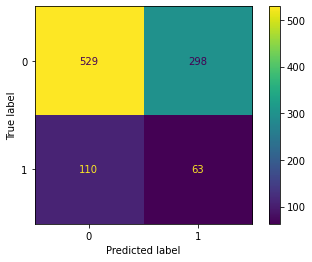

In [3]:
# set my parameters
maxIter = 1000
lr = 10
sigma = 0.1
alpha = np.zeros(4)

# create the ML dataframes
x_train_1 = x_train.loc[:, ['x', 'y']]
x_test_1 = x_test.loc[:, ['x', 'y']]

my_log_reg = custom_log_reg(kernel='gaussian', hyper_kernel=sigma)
costs = my_log_reg.fit(X=x_train_1, y=y_train, lr=lr, max_steps=maxIter, Lambda = 0.001, verbose = True, epsilon=1e-6)

# assess the results!
Z = my_log_reg.predict(x_test_1, threshold=0.5)
Z_train = my_log_reg.predict(x_train_1, threshold=0.5)

print("-----------------------------------")
print("The accuracy score on train resulted to be: {}".format(accuracy_score(Z_train, y_train)))
print("The accuracy score on test resulted to be: {}".format(accuracy_score(Z, y_test)))

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(Z, y_test))
disp.plot()

In [4]:
my_log_reg.alphas

array([-5.02043529e+00, -4.87712902e+00,  4.27871480e+01, -3.34382185e+00,
        5.33612039e+00, -3.13756241e+01, -3.73445265e+01, -5.50461910e+00,
        3.90406334e+00,  2.35061935e+00, -9.03779950e-01,  3.57882062e+00,
       -1.29365440e+01, -9.44164613e-01, -1.81192399e+00,  1.87396604e+00,
       -5.92049296e+01,  2.72314817e+00, -1.90832896e+01, -4.20249793e+01,
        5.97588296e+00,  6.92503020e+00,  1.19894775e+01, -1.32831460e+01,
        3.82462553e+00,  1.56896122e+01, -4.01498724e+00,  6.82693431e+00,
        1.01393252e+01, -5.92261473e+00,  1.18565615e-01, -4.70632278e+01,
       -3.80730179e-01, -3.13060211e+01, -3.89456257e+01,  3.59255894e+00,
        3.70185090e+01, -4.28874344e+00, -1.24102825e+01,  2.43642846e+00,
       -4.39599783e+01, -8.07660071e+00,  3.30490289e+00,  1.87111602e+01,
       -1.58598429e+01,  2.39261607e+00,  1.15142679e+00, -1.11505061e+00,
        5.23300210e+00,  1.17283898e-04, -3.76225223e+01, -1.44029176e+01,
        9.71056388e-01,  

# subtask 2: get better results!

In this task we use all the training data to do the regression. Since we are using a lot of features we need to have fast kernel computations i.e. not computing puntually each element of the kernel matrix! A nice way to do that is using the fact that you can compute the norm of each element of the design matrix and storing it. This avoid to compute the norm each iteration saving time, in fact that ||x_i-x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i^T * x_j.
I also implemented the operations s.t. we are using matrix notation, making it more readable.

I decided to use a custom kernel structured as the product of two different kernels


-----------------------------------
The accuracy score on train resulted to be: 0.615
The accuracy score on test resulted to be: 0.428


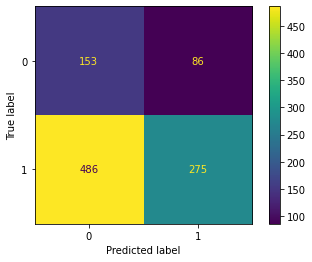

In [5]:
# set my parameters
maxIter = 2000
lr = 0.01
sigma_1 = 0.01
sigma_2 = 0.1
para_sum = 1
Lambda = 0.00001
alpha = np.zeros(4)

my_log_reg = custom_log_reg(kernel='custom', hyper_kernel=(sigma_1, sigma_1, para_sum))
costs = my_log_reg.fit(X=x_train, y=y_train, lr=lr, max_steps=maxIter, Lambda = Lambda, verbose = True)

# assess the results!
Z = my_log_reg.predict(x_test, threshold=0.5)
Z_train = my_log_reg.predict(x_train, threshold=0.5)

print("-----------------------------------")
print("The accuracy score on train resulted to be: {}".format(accuracy_score(Z_train, y_train)))
print("The accuracy score on test resulted to be: {}".format(accuracy_score(Z, y_test)))

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(Z, y_test))
disp.plot()


# Try some Grid_search cross validation!

In [6]:
# set my parameters
maxIter = 600
lr = 10

grid_sigma1 = [1e-3, 1e-2, 1e-1, 1]
grid_sigma2 = [1e-3, 1e-2, 1e-1, 1]
grid_sum = [0, 0.25, 0.5, 0.75, 1]
grid_Lambda = [1e-5, 1e-3, 1e-1]

params = []
accuracies_test = []
accuracies_train = []

num_train = len(grid_sigma1) * len(grid_sigma2) * len(grid_sum) * len(grid_Lambda) 
counter = 1

for sigma_1 in grid_sigma1:
    for sigma_2 in grid_sigma2:
        for para_sum in grid_sum:
            for Lambda in grid_Lambda:
                my_log_reg = custom_log_reg(kernel='custom', hyper_kernel=(sigma_1, sigma_2, para_sum))
                costs = my_log_reg.fit(X=x_train, y=y_train, lr=lr, max_steps=maxIter, Lambda = Lambda, epsilon = 1e-5)
                
                # assess the results!
                Z = my_log_reg.predict(x_test, threshold=0.5)
                Z_train = my_log_reg.predict(x_train, threshold=0.5)
                
                # saving accuracies and settings
                accuracies_test.append(accuracy_score(y_test, Z))
                accuracies_train.append(accuracy_score(y_train, Z_train))
                params.append({
                    "sigma_spatial" : sigma_1,
                    "sigma_total" : sigma_2,
                    "sum_factor" : para_sum,
                    "Lambda" : Lambda
                })
                
                # progresses
                print("Traings done : {} / {}".format(counter, num_train), end="\r")
                counter += 1

In [7]:
print("The best result is {} with the following hyperparameters:".format(max(accuracies_test)))
index_max = np.argmax(accuracies_test)
print(params[index_max])

The best result is 0.639 with the following hyperparameters:
{'sigma_spatial': 0.001, 'sigma_total': 1, 'sum_factor': 0.25, 'Lambda': 1e-05}


# Subtask 3: support planning 1

In [ ]:
# constrain
k = 50
C = np.matrix([[0, 10], [1, 1]])